In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import statistics as stats
import matplotlib as mpl

from matplotlib import colorbar
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature  
from cartopy.util import add_cyclic_point
import cmocean

from glob import glob
import xclim

import netCDF4 as nc

from xclim.ensembles import create_ensemble
from xclim import ensembles
mpl.rcParams['figure.figsize'] = [10,4]
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['savefig.dpi'] = 500

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['lines.linewidth']= 2.0

#### Historical (2010 - 2019)

##### Air temperature 

In [2]:
hist = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001/atm/proc/tseries/month_1/b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001.cam.h0.TS.185001-201412.nc'
ssp = '/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h0.TS.201501-206412.nc'

To preserve NetCDF structure and attributes, I used xarray.concat instead of NumPy.append (NumPy converts your xarray.DataArray into a plain NumPy array, which strips all the metadata; dimensions, attributes, & coordinates)

In [3]:
def combineFiles_2(file1,file2,histStart_year,histEnd_year,sspEnd_year,var):
    # Open datasets
    HIST = xr.open_mfdataset(file1)
    SSP = xr.open_mfdataset(file2)

    # Time slicing
    CESM_HIST_TS = HIST[var].sel(time=slice(f'{histStart_year}-01-01', f'{histEnd_year}-12-31'))
    CESM_SSP_TS = SSP[var].sel(time=slice(f'{histEnd_year}-01-01', f'{sspEnd_year}-12-31'))

    # Concatenate using xarray (along time)
    CESM_WACCM_TS_1 = xr.concat([CESM_HIST_TS, CESM_SSP_TS], dim='time')
    
    return CESM_WACCM_TS_1

In [4]:
CESM_WACCM_TS_001_1 = combineFiles_2(hist, ssp, 2010, 2015, 2019, 'TS')

In [5]:
CESM_WACCM_TS_001_1.shape

(120, 192, 288)

In [6]:
CESM_WACCM_TS_001_1

<xarray.DataArray 'TS' (time: 120, lat: 192, lon: 288)>
dask.array<concatenate, shape=(120, 192, 288), dtype=float32, chunksize=(61, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2010-01-01 00:00:00 ... 2019-12-01 00:00:00
Attributes:
    units:         K
    long_name:     Surface temperature (radiative)
    cell_methods:  time: mean

In [7]:
CESM_WACCM_TS_001_1.to_netcdf("CESM.WACCM.001.TS.201001-201931.nc")

In [8]:
TS_2010 = xr.open_dataset('CESM.WACCM.001.TS.201001-201931.nc')
TS_2010

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 120)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2010-01-01 00:00:00 ... 2019-12-01 00:00:00
Data variables:
    TS       (time, lat, lon) float32 ...

In [9]:
# Load data into memory
TS_2010.load()

# Dictionary to store the monthly climatology data
TS_2010_data = {}
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Group data by month and calculate the mean along the time dimension
for month_index, month_name in enumerate(months, start=1):
    current_month_data = TS_2010['TS'].where(
        TS_2010['time'].dt.month == month_index, drop=True
    ).mean(dim="time")
    TS_2010_data[month_name] = current_month_data

#### Long-term maximum air temperature of 2010-2020

In [10]:
yearly_max_TS_2010 = TS_2010['TS'].resample(time='1MS').mean().groupby('time.year').max()
long_term_TS_max_2010 = yearly_max_TS_2010.mean(dim='year') - 273.15
long_term_TS_max_2010.attrs['units'] = '°C'

In [11]:
long_term_TS_max_2010

<xarray.DataArray 'TS' (lat: 192, lon: 288)>
array([[-26.019058  , -26.019089  , -26.019104  , ..., -26.019043  ,
        -26.019058  , -26.019089  ],
       [-25.439697  , -25.478607  , -25.611786  , ..., -25.399017  ,
        -25.410614  , -25.42566   ],
       [-24.992767  , -25.035004  , -25.061493  , ..., -24.747986  ,
        -24.814392  , -24.887054  ],
       ...,
       [ -0.26263428,  -0.26272583,  -0.26293945, ...,  -0.2624817 ,
         -0.26254272,  -0.26263428],
       [ -0.26901245,  -0.2690735 ,  -0.26916504, ...,  -0.26901245,
         -0.26889038,  -0.26898193],
       [ -0.26449585,  -0.26449585,  -0.26452637, ...,  -0.26446533,
         -0.26446533,  -0.26449585]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    units:    °C

In [12]:
long_term_TS_max_2010.to_netcdf('AirTemperature_Surface_Ltmax_2010-2020.nc')

In [43]:
TS_max_2010 = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/AirTemperature_Surface_Ltmax_2010-2020.nc')
TS_max_2010

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    TS       (lat, lon) float32 ...

#### Plot for Air Temp. Max 2010-2020

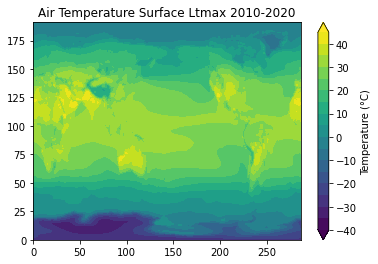

In [44]:
TS_max_2010_data = np.array(TS_max_2010['TS'])
levels = np.arange(-40, 50, 5)
contour = plt.contourf(TS_max_2010_data, levels=levels, extend='both')
plt.title('Air Temperature Surface Ltmax 2010-2020')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature (°C)')
plt.show()

#### Long-term minimum air temperature of 2010-2020

In [16]:
yearly_min_TS_2010 = TS_2010['TS'].resample(time='1MS').mean().groupby('time.year').min()
long_term_TS_min_2010 = yearly_min_TS_2010.mean(dim='year') - 273.15
long_term_TS_min_2010.attrs['units'] = '°C'

In [17]:
long_term_TS_min_2010

<xarray.DataArray 'TS' (lat: 192, lon: 288)>
array([[-61.42485 , -61.42485 , -61.42485 , ..., -61.42485 , -61.42485 ,
        -61.42485 ],
       [-61.212173, -61.24164 , -61.378723, ..., -61.201416, -61.201706,
        -61.207   ],
       [-60.750977, -60.78151 , -60.79521 , ..., -60.557556, -60.59648 ,
        -60.6559  ],
       ...,
       [-29.681046, -29.651855, -29.623428, ..., -29.759705, -29.734268,
        -29.709167],
       [-29.688599, -29.67572 , -29.662155, ..., -29.730682, -29.715576,
        -29.701782],
       [-29.667038, -29.666199, -29.665451, ..., -29.670013, -29.668915,
        -29.667908]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    units:    °C

In [18]:
long_term_TS_min_2010.to_netcdf('AirTemperature_Surface_Ltmin_2010-2020.nc')

In [45]:
TS_min_2010 = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/AirTemperature_Surface_Ltmax_2010-2020.nc')
TS_min_2010

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    TS       (lat, lon) float32 ...

#### Plot for Air Temp. Min 2010-2020

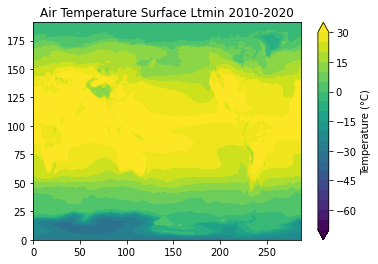

In [46]:
TS_min_2010_data = np.array(TS_min_2010['TS'])
levels = np.arange(-70, 35, 5)
contour = plt.contourf(TS_min_2010_data, levels=levels, extend='both')
plt.title('Air Temperature Surface Ltmin 2010-2020')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature (°C)')
plt.show()

#### Sea surface temperature 

In [21]:
sim='001';var = 'TEMP'
hist ='/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001/ocn/proc/tseries/month_1/'+ 'b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001.pop.h.TEMP.185001-201412.nc'
ssp = '/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.'+sim+'/ocn/proc/tseries/month_1/'+ 'b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.'+sim+'.pop.h.'+var+'.*' + '.nc'

#### We need to add an extra line of code to be able to get the sea surface (z_t=0)

In [24]:
def combineFiles_2(file1,file2,histStart_year,histEnd_year,sspEnd_year,var):
    HIST = xr.open_mfdataset(file1)
    SSP = xr.open_mfdataset(file2)
    
    CESM_HIST_SST = HIST[var].sel(time=slice(f'{histStart_year}-01-01', f'{histEnd_year}-12-31')).isel(z_t=0 ) #add isel(z_t=0) to both lines
    CESM_SSP_SST = SSP[var].sel(time=slice(f'{histEnd_year}-01-01', f'{sspEnd_year}-12-31')).isel(z_t=0 )
    
    CESM_WACCM_SST_1 = xr.concat([CESM_HIST_SST, CESM_SSP_SST], dim='time')
    
    return CESM_WACCM_SST_1

In [25]:
CESM_WACCM_SST_001_1 = combineFiles_2(hist, ssp, 2010, 2015, 2019, 'TEMP')

In [26]:
CESM_WACCM_SST_001_1.shape

(120, 384, 320)

In [27]:
CESM_WACCM_SST_001_1

<xarray.DataArray 'TEMP' (time: 120, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(120, 384, 320), dtype=float32, chunksize=(61, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    z_t      float32 500.0
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
  * time     (time) object 2010-01-01 00:00:00 ... 2019-12-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [28]:
CESM_WACCM_SST_001_1.to_netcdf('CESM.WACCM.001.SST.201001-201931.nc')

In [29]:
SST_2010 = xr.open_dataset('CESM.WACCM.001.SST.201001-201931.nc')
SST_2010

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 120)
Coordinates:
    z_t      float32 ...
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
  * time     (time) object 2010-01-01 00:00:00 ... 2019-12-01 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (time, nlat, nlon) float32 ...

In [30]:
SST_2010.load()

SST_2010_data = {}
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

for month_index, month_name in enumerate(months, start=1):
    current_month_data = SST_2010['TEMP'].where(
        SST_2010['time'].dt.month == month_index, drop=True
    ).mean(dim="time")
    SST_2010_data[month_name] = current_month_data

#### Long-term maximum sea surface temperature of 2010-2020

In [31]:
yearly_max_SST_2010 = SST_2010['TEMP'].resample(time='1MS').mean().groupby('time.year').max()
long_term_SST_max_2010 = yearly_max_SST_2010.mean(dim='year')
long_term_SST_max_2010.attrs['units'] = '°C'

In [32]:
long_term_SST_max_2010

<xarray.DataArray 'TEMP' (nlat: 384, nlon: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [-1.8661804, -1.8656852, -1.8649886, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    z_t      float32 500.0
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: nlat, nlon
Attributes:
    units:    °C

In [33]:
long_term_SST_max_2010.to_netcdf('OceanTemperature Surface LtMax 2010-2020.nc')

In [47]:
SST_max_2010 = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/OceanTemperature Surface LtMax 2010-2020.nc')
SST_max_2010

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320)
Coordinates:
    z_t      float32 ...
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (nlat, nlon) float32 ...

#### Plot for Ocean Temp. Max 2010-2020

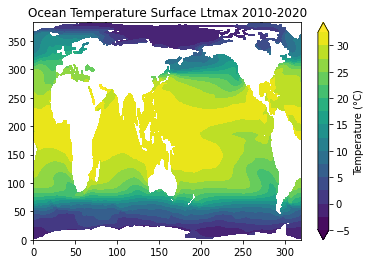

In [48]:
SST_max_2010_data = np.array(SST_max_2010['TEMP'])
levels = np.arange(-5, 35, 2.5)
contour = plt.contourf(SST_max_2010_data, levels=levels, extend='both')
plt.title('Ocean Temperature Surface Ltmax 2010-2020')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature (°C)')
plt.show()

#### Long-term minimum ocean temperature of 2010-2020

In [36]:
yearly_min_SST_2010 = SST_2010['TEMP'].resample(time='1MS').mean().groupby('time.year').min()
long_term_SST_min_2010 = yearly_min_SST_2010.mean(dim='year')
long_term_SST_min_2010.attrs['units'] = '°C'

In [37]:
long_term_SST_min_2010

<xarray.DataArray 'TEMP' (nlat: 384, nlon: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [-1.9056005, -1.9055754, -1.9054596, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    z_t      float32 500.0
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: nlat, nlon
Attributes:
    units:    °C

In [38]:
long_term_SST_min_2010.to_netcdf('OceanTemperature Surface LtMin 2010-2020.nc')

In [49]:
SST_min_2010 = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/OceanTemperature Surface LtMin 2010-2020.nc')
SST_min_2010

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320)
Coordinates:
    z_t      float32 ...
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (nlat, nlon) float32 ...

#### Plot for Ocean Temp. Min 2010-2020

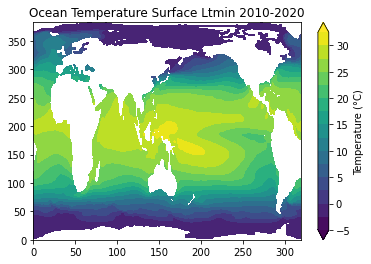

In [50]:
SST_min_2010_data = np.array(SST_min_2010['TEMP'])
levels = np.arange(-5, 35, 2.5)
contour = plt.contourf(SST_min_2010_data, levels=levels, extend='both')
plt.title('Ocean Temperature Surface Ltmin 2010-2020')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature (°C)')
plt.show()

#### Precipitation

In [41]:
hist_prect = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001/atm/proc/tseries/month_1/b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001.cam.h0.PRECT.185001-201412.nc'
ssp_prect = '/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h0.PRECT.201501-206412.nc'

In [42]:
def combineFiles_2(file1,file2,histStart_year,histEnd_year,sspEnd_year,var):
    # Open datasets
    HIST = xr.open_mfdataset(file1)
    SSP = xr.open_mfdataset(file2)

    # Time slicing
    CESM_HIST_PRECT = HIST[var].sel(time=slice(f'{histStart_year}-01-01', f'{histEnd_year}-12-31'))
    CESM_SSP_PRECT = SSP[var].sel(time=slice(f'{histEnd_year}-01-01', f'{sspEnd_year}-12-31'))

    # Concatenate using xarray (along time)
    CESM_WACCM_PRECT_1 = xr.concat([CESM_HIST_PRECT, CESM_SSP_PRECT], dim='time')
    
    return CESM_WACCM_PRECT_1

In [43]:
CESM_WACCM_PRECT_001_1 = combineFiles_2(hist_prect, ssp_prect, 2010, 2015, 2019, 'PRECT')

In [44]:
CESM_WACCM_PRECT_001_1.to_netcdf('CESM.WACCM.001.PRECT.201001-201931.nc')

In [5]:
PRECT_2010 = xr.open_dataset('CESM.WACCM.001.PRECT.201001-201931.nc')
PRECT_2010

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 120)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2010-01-01 00:00:00 ... 2019-12-01 00:00:00
Data variables:
    PRECT    (time, lat, lon) float32 ...

In [6]:
PRECT_2010.load()

PRECT_2010_data = {}
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Group data by month and calculate the mean along the time dimension
for month_index, month_name in enumerate(months, start=1):
    current_month_data = PRECT_2010['PRECT'].where(
        PRECT_2010['time'].dt.month == month_index, drop=True
    ).mean(dim="time")
    PRECT_2010_data[month_name] = current_month_data

In [7]:
yearly_PRECT_2010 = PRECT_2010['PRECT'].resample(time='1MS').mean().groupby('time.year').min()
long_term_PRECT_2010 = yearly_PRECT_2010.mean(dim='year')* 3.1536e7 * 1000
long_term_PRECT_2010.attrs['units'] = 'mm/y'

In [8]:
long_term_PRECT_2010

<xarray.DataArray 'PRECT' (lat: 192, lon: 288)>
array([[28.62333 , 28.623337, 28.623302, ..., 28.623322, 28.623312,
        28.623323],
       [22.428988, 22.405602, 22.394053, ..., 22.613731, 22.544079,
        22.474558],
       [17.319643, 17.106941, 16.928173, ..., 17.852493, 17.679321,
        17.514782],
       ...,
       [87.83536 , 87.96383 , 88.13098 , ..., 87.37019 , 87.58929 ,
        87.765945],
       [77.85911 , 77.83959 , 77.74268 , ..., 78.50568 , 78.012505,
        77.9536  ],
       [73.20879 , 73.209114, 73.21002 , ..., 73.208755, 73.20875 ,
        73.20878 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    units:    mm/y

In [15]:
long_term_PRECT_2010.max()

<xarray.DataArray 'PRECT' ()>
array(3134.68920898)

In [11]:
long_term_PRECT_2010.to_netcdf('Precipitation Surface Ltmin 2010-2020.nc')

In [51]:
PRECT_2010 = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/Precipitation Surface Ltmin 2010-2020.nc')
PRECT_2010

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    PRECT    (lat, lon) float32 ...

### Future

#### SSP 2-4.5 

#### Air Temperature 

#### 2040–2049

In [18]:
ssp = xr.open_dataset('/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h0.TS.201501-206412.nc')

In [19]:
ssp = ssp['TS']

In [21]:
ssp_2040 = ssp.sel(time=slice("2040-01-01", "2049-12-31"))
ssp_2040

<xarray.DataArray 'TS' (time: 120, lat: 192, lon: 288)>
[6635520 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2040-01-01 00:00:00 ... 2049-12-01 00:00:00
Attributes:
    units:         K
    long_name:     Surface temperature (radiative)
    cell_methods:  time: mean

In [22]:
ssp_2040.to_netcdf("CESM.WACCM.001.SSP245.TS.2040-2049.nc")

In [23]:
SSP_TS = xr.open_dataset('CESM.WACCM.001.SSP245.TS.2040-2049.nc')
SSP_TS

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 120)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2040-01-01 00:00:00 ... 2049-12-01 00:00:00
Data variables:
    TS       (time, lat, lon) float32 ...

In [24]:
SSP_TS.load()

# Dictionary to store the monthly climatology data
SSP_TS_DATA = {}
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Group data by month and calculate the mean along the time dimension
for month_index, month_name in enumerate(months, start=1):
    current_month_data = SSP_TS['TS'].where(
        SSP_TS['time'].dt.month == month_index, drop=True
    ).mean(dim="time")
    SSP_TS_DATA[month_name] = current_month_data

#### Long-term maximum air temperature of 2040-2049

In [25]:
future_yearly_max = SSP_TS['TS'].resample(time='1MS').mean().groupby('time.year').max()
future_long_term_max_air_temp = future_yearly_max.mean(dim='year') - 273.15
future_long_term_max_air_temp.attrs['units'] = '°C'

In [26]:
future_long_term_max_air_temp

<xarray.DataArray 'TS' (lat: 192, lon: 288)>
array([[-25.687683  , -25.687592  , -25.687714  , ..., -25.687637  ,
        -25.687668  , -25.687683  ],
       [-25.000702  , -25.042053  , -25.182663  , ..., -24.93872   ,
        -24.956467  , -24.978775  ],
       [-24.413712  , -24.461807  , -24.496552  , ..., -24.179092  ,
        -24.234634  , -24.311249  ],
       ...,
       [ -0.2809143 ,  -0.2805786 ,  -0.280365  , ...,  -0.28225708,
         -0.28182983,  -0.28134155],
       [ -0.2769165 ,  -0.27713013,  -0.2772827 , ...,  -0.27648926,
         -0.2765503 ,  -0.2767334 ],
       [ -0.26663208,  -0.26663208,  -0.26663208, ...,  -0.26663208,
         -0.26663208,  -0.26663208]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    units:    °C

In [27]:
future_long_term_max_air_temp.to_netcdf("AirTemperature_Surface_Ltmax_2040-2049.nc")

In [41]:
Air_temp_max_2040 = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/AirTemperature_Surface_Ltmax_2040-2049.nc')
Air_temp_max_2040

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    TS       (lat, lon) float32 ...

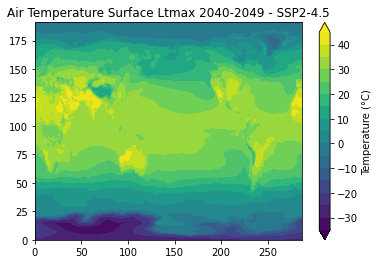

In [42]:
Air_temp_max_2040_data = np.array(Air_temp_max_2040['TS'])
levels = np.arange(-35, 50, 5)
contour = plt.contourf(Air_temp_max_2040_data, levels=levels, extend='both')
plt.title('Air Temperature Surface Ltmax 2040-2049 - SSP2-4.5')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature (°C)')
plt.show()

#### Long-term minimum air temperature of 2040-2049

In [37]:
future_yearly_min = SSP_TS['TS'].resample(time='1MS').mean().groupby('time.year').min()
future_long_term_min_air_temp = future_yearly_min.mean(dim='year') - 273.15
future_long_term_min_air_temp.attrs['units'] = '°C'

In [39]:
future_long_term_min_air_temp.to_netcdf("AirTemperature_Surface_Ltmin_2040-2049.nc")

In [58]:
Air_temp_min_2040 = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/AirTemperature_Surface_Ltmin_2040-2049.nc')
Air_temp_min_2040

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    TS       (lat, lon) float32 ...

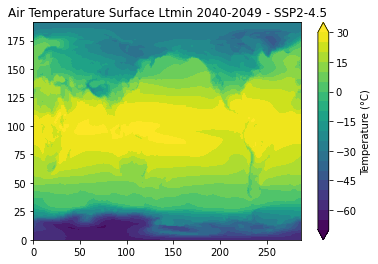

In [59]:
Air_temp_min_2040_data = np.array(Air_temp_min_2040['TS'])
levels = np.arange(-70, 35, 5)
contour = plt.contourf(Air_temp_min_2040_data, levels=levels, extend='both')
plt.title('Air Temperature Surface Ltmin 2040-2049 - SSP2-4.5')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature (°C)')
plt.show()

#### 2050–2059

In [61]:
ssp = xr.open_dataset('/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h0.TS.201501-206412.nc')

ssp = ssp['TS']

ssp_2050 = ssp.sel(time=slice("2050-01-01", "2059-12-31"))
ssp_2050

ssp_2050.to_netcdf("CESM.WACCM.001.SSP245.TS.2050-2059.nc")

SSP_TS = xr.open_dataset('CESM.WACCM.001.SSP245.TS.2050-2059.nc')
SSP_TS

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 120)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2050-01-01 00:00:00 ... 2059-12-01 00:00:00
Data variables:
    TS       (time, lat, lon) float32 ...

In [62]:
SSP_TS.load()

# Dictionary to store the monthly climatology data
SSP_TS_DATA = {}
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Group data by month and calculate the mean along the time dimension
for month_index, month_name in enumerate(months, start=1):
    current_month_data = SSP_TS['TS'].where(
        SSP_TS['time'].dt.month == month_index, drop=True
    ).mean(dim="time")
    SSP_TS_DATA[month_name] = current_month_data

#### Long-term maximum air temperature of 2050-2059

In [63]:
future_yearly_max = SSP_TS['TS'].resample(time='1MS').mean().groupby('time.year').max()
future_long_term_max_air_temp = future_yearly_max.mean(dim='year') - 273.15
future_long_term_max_air_temp.attrs['units'] = '°C'

In [64]:
future_long_term_max_air_temp.to_netcdf("AirTemperature_Surface_Ltmax_2050-2059.nc")

In [68]:
Air_temp_max_2050 = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/AirTemperature_Surface_Ltmax_2050-2059.nc')
Air_temp_max_2050

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    TS       (lat, lon) float32 ...

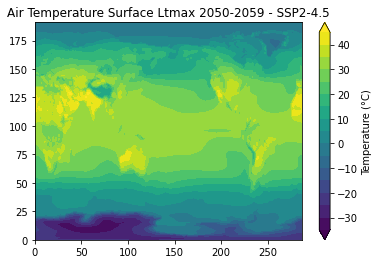

In [69]:
Air_temp_max_2050_data = np.array(Air_temp_max_2050['TS'])
levels = np.arange(-35, 50, 5)
contour = plt.contourf(Air_temp_max_2050_data, levels=levels, extend='both')
plt.title('Air Temperature Surface Ltmax 2050-2059 - SSP2-4.5')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature (°C)')
plt.show()

#### Long-term minimum air temperature of 2050-2059

In [70]:
future_yearly_min = SSP_TS['TS'].resample(time='1MS').mean().groupby('time.year').min()
future_long_term_min_air_temp = future_yearly_min.mean(dim='year') - 273.15
future_long_term_min_air_temp.attrs['units'] = '°C'

future_long_term_min_air_temp.to_netcdf("AirTemperature_Surface_Ltmin_2050-2059.nc")

Air_temp_min_2050 = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/AirTemperature_Surface_Ltmin_2050-2059.nc')
Air_temp_min_2050

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    TS       (lat, lon) float32 ...

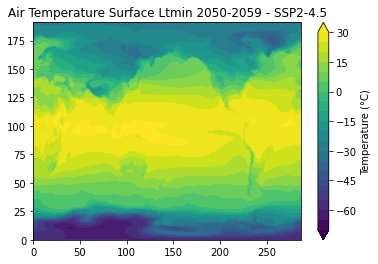

In [71]:
Air_temp_min_2050_data = np.array(Air_temp_min_2050['TS'])
levels = np.arange(-70, 35, 5)
contour = plt.contourf(Air_temp_min_2050_data, levels=levels, extend='both')
plt.title('Air Temperature Surface Ltmin 2050-2059 - SSP2-4.5')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature (°C)')
plt.show()

#### 2060–2069

In [74]:
ssp_1 = '/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h0.TS.201501-206412.nc'
ssp_2 = '/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h0.TS.206501-210012.nc'

In [75]:
def combineFiles_2(file1,file2,ssp_1_Start_year,ssp_1_End_year,ssp_2_End_year,var):
    # Open datasets
    SSP_1 = xr.open_mfdataset(file1)
    SSP_2 = xr.open_mfdataset(file2)

    # Time slicing
    CESM_SSP_1_TS = SSP_1[var].sel(time=slice(f'{ssp_1_Start_year}-01-01', f'{ssp_1_End_year}-12-31'))
    CESM_SSP_2_TS = SSP_2[var].sel(time=slice(f'{ssp_1_End_year}-01-01', f'{ssp_2_End_year}-12-31'))

    # Concatenate using xarray (along time)
    CESM_WACCM_SSP_TS_1 = xr.concat([CESM_SSP_1_TS, CESM_SSP_2_TS], dim='time')
    
    return CESM_WACCM_SSP_TS_1


CESM_WACCM_SSP_TS_001_1 = combineFiles_2(ssp_1, ssp_2, 2060, 2065, 2069, 'TS')
CESM_WACCM_SSP_TS_001_1.shape

(120, 192, 288)

In [76]:
CESM_WACCM_SSP_TS_001_1

<xarray.DataArray 'TS' (time: 120, lat: 192, lon: 288)>
dask.array<concatenate, shape=(120, 192, 288), dtype=float32, chunksize=(61, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2060-01-01 00:00:00 ... 2069-12-01 00:00:00
Attributes:
    units:         K
    long_name:     Surface temperature (radiative)
    cell_methods:  time: mean

In [78]:
CESM_WACCM_SSP_TS_001_1.to_netcdf("CESM.WACCM.001.SSP245.TS.206001-206931.nc")

In [79]:
SSP_TS_2060 = xr.open_dataset('CESM.WACCM.001.SSP245.TS.206001-206931.nc')
SSP_TS_2060

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 120)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2060-01-01 00:00:00 ... 2069-12-01 00:00:00
Data variables:
    TS       (time, lat, lon) float32 ...

In [80]:

SSP_TS_2060.load()

# Dictionary to store the monthly climatology data
SSP_TS_2060_data = {}
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Group data by month and calculate the mean along the time dimension
for month_index, month_name in enumerate(months, start=1):
    current_month_data = SSP_TS_2060['TS'].where(
        SSP_TS_2060['time'].dt.month == month_index, drop=True
    ).mean(dim="time")
    SSP_TS_2060_data[month_name] = current_month_data

#### Long-term maximum air temperature of 2060-2069

In [81]:
future_yearly_max = SSP_TS_2060['TS'].resample(time='1MS').mean().groupby('time.year').max()
future_long_term_max_air_temp = future_yearly_max.mean(dim='year') - 273.15
future_long_term_max_air_temp.attrs['units'] = '°C'

future_long_term_max_air_temp.to_netcdf("AirTemperature_Surface_Ltmax_2060-2069.nc")

In [85]:
Air_temp_max_2060 = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/AirTemperature_Surface_Ltmax_2060-2069.nc')
Air_temp_max_2060

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    TS       (lat, lon) float32 ...

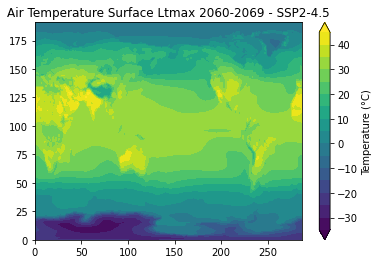

In [86]:
Air_temp_max_2060_data = np.array(Air_temp_max_2060['TS'])
levels = np.arange(-35, 50, 5)
contour = plt.contourf(Air_temp_max_2050_data, levels=levels, extend='both')
plt.title('Air Temperature Surface Ltmax 2060-2069 - SSP2-4.5')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature (°C)')
plt.show()

#### Long-term minimum air temperature of 2060-2069

In [89]:
future_yearly_min = SSP_TS_2060['TS'].resample(time='1MS').mean().groupby('time.year').min()
future_long_term_min_air_temp = future_yearly_min.mean(dim='year') - 273.15
future_long_term_min_air_temp.attrs['units'] = '°C'

future_long_term_min_air_temp.to_netcdf("AirTemperature_Surface_Ltmin_2060-2069.nc")

Air_temp_min_2060 = xr.open_dataset('/glade/work/kasante/MANGROVE_SDM/AirTemperature_Surface_Ltmin_2060-2069.nc')
Air_temp_min_2060

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    TS       (lat, lon) float32 ...

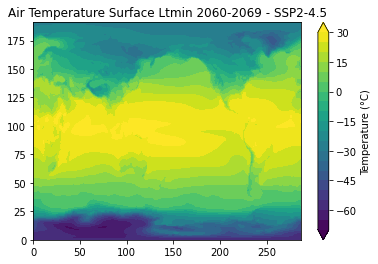

In [90]:
Air_temp_min_2060_data = np.array(Air_temp_min_2060['TS'])
levels = np.arange(-70, 35, 5)
contour = plt.contourf(Air_temp_min_2060_data, levels=levels, extend='both')
plt.title('Air Temperature Surface Ltmin 2060-2069 - SSP2-4.5')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature (°C)')
plt.show()

#### Sea Surface Temperature

#### 2040–2049

In [93]:
sst = xr.open_dataset('/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/ocn/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.pop.h.TEMP.201501-206412.nc')

sst = sst['TEMP']
sst_2040 = sst.sel(time=slice("2040-01-01", "2049-12-31")).isel(z_t=0)
sst_2040

sst_2040.to_netcdf("CESM.WACCM.001.SSP245.SST.2040-2049.nc")

SSP_SST = xr.open_dataset('CESM.WACCM.001.SSP245.SST.2040-2049.nc')
SSP_SST

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 120)
Coordinates:
    z_t      float32 ...
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
  * time     (time) object 2040-01-01 00:00:00 ... 2049-12-01 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (time, nlat, nlon) float32 ...

In [96]:
SSP_SST.load()

SSP_SST_2040_data = {}
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

for month_index, month_name in enumerate(months, start=1):
    current_month_data = SSP_SST['TEMP'].where(
        SSP_SST['time'].dt.month == month_index, drop=True
    ).mean(dim="time")
    SSP_SST_2040_data[month_name] = current_month_data

#### Long-term maximum sea surface temperature of 2040-2049

In [97]:
yearly_max_SST_2040 = SSP_SST['TEMP'].resample(time='1MS').mean().groupby('time.year').max()
long_term_SST_max_2040 = yearly_max_SST_2040.mean(dim='year')
long_term_SST_max_2040.attrs['units'] = '°C'

long_term_SST_max_2040

long_term_SST_max_2040.to_netcdf('OceanTemperature Surface LtMax 2040-2049.nc')

#### Long-term minimum sea surface temperature of 2040-2049

In [98]:
yearly_min_SST_2040 = SSP_SST['TEMP'].resample(time='1MS').mean().groupby('time.year').min()
long_term_SST_min_2040 = yearly_min_SST_2040.mean(dim='year')
long_term_SST_min_2040.attrs['units'] = '°C'

long_term_SST_min_2040

long_term_SST_min_2040.to_netcdf('OceanTemperature Surface LtMin 2040-2049.nc')

#### 2050–2059

In [99]:
sst = xr.open_dataset('/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/ocn/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.pop.h.TEMP.201501-206412.nc')

sst = sst['TEMP']
sst_2050 = sst.sel(time=slice("2050-01-01", "2059-12-31")).isel(z_t=0)
sst_2050

sst_2050.to_netcdf("CESM.WACCM.001.SSP245.SST.2050-2059.nc")

SSP_SST = xr.open_dataset('CESM.WACCM.001.SSP245.SST.2050-2059.nc')
SSP_SST

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 120)
Coordinates:
    z_t      float32 ...
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
  * time     (time) object 2050-01-01 00:00:00 ... 2059-12-01 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (time, nlat, nlon) float32 ...

In [100]:
SSP_SST.load()

SSP_SST_2050_data = {}
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

for month_index, month_name in enumerate(months, start=1):
    current_month_data = SSP_SST['TEMP'].where(
        SSP_SST['time'].dt.month == month_index, drop=True
    ).mean(dim="time")
    SSP_SST_2050_data[month_name] = current_month_data

#### Long-term maximum sea surface temperature of 2050-2059

In [101]:
yearly_max_SST_2050 = SSP_SST['TEMP'].resample(time='1MS').mean().groupby('time.year').max()
long_term_SST_max_2050 = yearly_max_SST_2050.mean(dim='year')
long_term_SST_max_2050.attrs['units'] = '°C'

long_term_SST_max_2050

long_term_SST_max_2050.to_netcdf('OceanTemperature Surface LtMax 2050-2059.nc')

#### Long-term minimum sea surface temperature of 2050-2059

In [102]:
yearly_min_SST_2050 = SSP_SST['TEMP'].resample(time='1MS').mean().groupby('time.year').min()
long_term_SST_min_2050 = yearly_min_SST_2050.mean(dim='year')
long_term_SST_min_2050.attrs['units'] = '°C'

long_term_SST_min_2050

long_term_SST_min_2050.to_netcdf('OceanTemperature Surface LtMin 2050-2059.nc')

#### 2060–2069

In [104]:
sst_1 = '/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/ocn/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.pop.h.TEMP.201501-206412.nc'
sst_2 = '/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/ocn/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.pop.h.TEMP.206501-210012.nc'

In [105]:
def combineFiles_2(file1,file2,sst_1_Start_year,sst_1_End_year,sst_2_End_year,var):
    # Open datasets
    SST_1 = xr.open_mfdataset(file1)
    SST_2 = xr.open_mfdataset(file2)

    # Time slicing
    CESM_SST_1 = SST_1[var].sel(time=slice(f'{sst_1_Start_year}-01-01', f'{sst_1_End_year}-12-31')).isel(z_t=0)
    CESM_SST_2 = SST_2[var].sel(time=slice(f'{sst_1_End_year}-01-01', f'{sst_2_End_year}-12-31')).isel(z_t=0)

    # Concatenate using xarray (along time)
    CESM_WACCM_SST_1 = xr.concat([CESM_SST_1, CESM_SST_2], dim='time')
    
    return CESM_WACCM_SST_1


CESM_WACCM_SST_001_1 = combineFiles_2(sst_1, sst_2, 2060, 2065, 2069, 'TEMP')
CESM_WACCM_SST_001_1.shape

(120, 384, 320)

In [106]:
CESM_WACCM_SST_001_1.to_netcdf("CESM.WACCM.001.SSP245.SST.206001-206931.nc")

In [107]:
SSP_SST = xr.open_dataset('CESM.WACCM.001.SSP245.SST.206001-206931.nc')
SSP_SST

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 120)
Coordinates:
    z_t      float32 ...
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
  * time     (time) object 2060-01-01 00:00:00 ... 2069-12-01 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (time, nlat, nlon) float32 ...

In [109]:
SSP_SST.load()

SSP_SST_2060_data = {}
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

for month_index, month_name in enumerate(months, start=1):
    current_month_data = SSP_SST['TEMP'].where(
        SSP_SST['time'].dt.month == month_index, drop=True
    ).mean(dim="time")
    SSP_SST_2060_data[month_name] = current_month_data

#### Long-term maximum sea surface temperature of 2060-2069

In [110]:
yearly_max_SST_2060 = SSP_SST['TEMP'].resample(time='1MS').mean().groupby('time.year').max()
long_term_SST_max_2060 = yearly_max_SST_2060.mean(dim='year')
long_term_SST_max_2060.attrs['units'] = '°C'

long_term_SST_max_2060

long_term_SST_max_2060.to_netcdf('OceanTemperature Surface LtMax 2060-2069.nc')

#### Long-term minimum sea surface temperature of 2060-2069

In [111]:
yearly_min_SST_2060 = SSP_SST['TEMP'].resample(time='1MS').mean().groupby('time.year').min()
long_term_SST_min_2060 = yearly_min_SST_2060.mean(dim='year')
long_term_SST_min_2060.attrs['units'] = '°C'

long_term_SST_min_2060

long_term_SST_min_2060.to_netcdf('OceanTemperature Surface LtMin 2060-2069.nc')

### Precipitation

#### 2040 - 2049

In [4]:
ssp_prect = xr.open_dataset('/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h0.PRECT.201501-206412.nc')
ssp_prect = ssp_prect['PRECT']

ssp_prect_2040 = ssp_prect.sel(time=slice("2040-01-01", "2049-12-31"))

ssp_prect_2040.to_netcdf('CESM.WACCM.001.SSP.PRECT.204001-204931.nc')

PRECT_2040 = xr.open_dataset('CESM.WACCM.001.SSP.PRECT.204001-204931.nc')
PRECT_2040

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 120)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2040-01-01 00:00:00 ... 2049-12-01 00:00:00
Data variables:
    PRECT    (time, lat, lon) float32 ...

In [5]:
PRECT_2040.load()

PRECT_2040_data = {}
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Group data by month and calculate the mean along the time dimension
for month_index, month_name in enumerate(months, start=1):
    current_month_data = PRECT_2040['PRECT'].where(
        PRECT_2040['time'].dt.month == month_index, drop=True
    ).mean(dim="time")
    PRECT_2040_data[month_name] = current_month_data

In [6]:
yearly_PRECT_2040 = PRECT_2040['PRECT'].resample(time='1MS').mean().groupby('time.year').min()
long_term_PRECT_2040 = yearly_PRECT_2040.mean(dim='year')* 3.1536e7 * 1000
long_term_PRECT_2040.attrs['units'] = 'mm/y'

In [7]:
long_term_PRECT_2040.to_netcdf('Precipitation Surface Ltmin 2040-2049.nc')

#### 2050 - 2059

In [8]:
ssp_prect = xr.open_dataset('/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h0.PRECT.201501-206412.nc')
ssp_prect = ssp_prect['PRECT']

ssp_prect_2050 = ssp_prect.sel(time=slice("2050-01-01", "2059-12-31"))

ssp_prect_2050.to_netcdf('CESM.WACCM.001.SSP.PRECT.205001-205931.nc')

PRECT_2050 = xr.open_dataset('CESM.WACCM.001.SSP.PRECT.205001-205931.nc')
PRECT_2050

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 120)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2050-01-01 00:00:00 ... 2059-12-01 00:00:00
Data variables:
    PRECT    (time, lat, lon) float32 ...

In [9]:
PRECT_2050.load()

PRECT_2050_data = {}
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Group data by month and calculate the mean along the time dimension
for month_index, month_name in enumerate(months, start=1):
    current_month_data = PRECT_2050['PRECT'].where(
        PRECT_2050['time'].dt.month == month_index, drop=True
    ).mean(dim="time")
    PRECT_2050_data[month_name] = current_month_data

In [10]:
yearly_PRECT_2050 = PRECT_2050['PRECT'].resample(time='1MS').mean().groupby('time.year').min()
long_term_PRECT_2050 = yearly_PRECT_2050.mean(dim='year')* 3.1536e7 * 1000
long_term_PRECT_2050.attrs['units'] = 'mm/y'

long_term_PRECT_2050.to_netcdf('Precipitation Surface Ltmin 2050-2059.nc')

#### 2060 - 2069

In [14]:
ssp_prect_1 = '/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h0.PRECT.201501-206412.nc'
ssp_prect_2 = '/glade/campaign/cesm/collections/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h0.PRECT.206501-210012.nc'

In [15]:
def combineFiles_2(file1,file2,prect_1_Start_year,prect_1_End_year,prect_2_End_year,var):
    # Open datasets
    PRECT_1 = xr.open_mfdataset(file1)
    PRECT_2 = xr.open_mfdataset(file2)

    # Time slicing
    CESM_PRECT_1 = PRECT_1[var].sel(time=slice(f'{prect_1_Start_year}-01-01', f'{prect_1_End_year}-12-31'))
    CESM_PRECT_2 = PRECT_2[var].sel(time=slice(f'{prect_1_End_year}-01-01', f'{prect_2_End_year}-12-31'))

    # Concatenate using xarray (along time)
    CESM_WACCM_PRECT_1 = xr.concat([CESM_PRECT_1, CESM_PRECT_2], dim='time')
    
    return CESM_WACCM_PRECT_1


CESM_WACCM_PRECT_001_1 = combineFiles_2(ssp_prect_1, ssp_prect_2, 2060, 2065, 2069, 'PRECT')
CESM_WACCM_PRECT_001_1.shape

(120, 192, 288)

In [16]:
CESM_WACCM_PRECT_001_1.to_netcdf('CESM.WACCM.001.SSP.PRECT.206001-206931.nc')

In [17]:
PRECT_2060 = xr.open_dataset('CESM.WACCM.001.SSP.PRECT.206001-206931.nc')
PRECT_2060

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 120)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2060-01-01 00:00:00 ... 2069-12-01 00:00:00
Data variables:
    PRECT    (time, lat, lon) float32 ...

In [18]:
PRECT_2060.load()

PRECT_2060_data = {}
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Group data by month and calculate the mean along the time dimension
for month_index, month_name in enumerate(months, start=1):
    current_month_data = PRECT_2060['PRECT'].where(
        PRECT_2060['time'].dt.month == month_index, drop=True
    ).mean(dim="time")
    PRECT_2060_data[month_name] = current_month_data

In [19]:
yearly_PRECT_2060 = PRECT_2060['PRECT'].resample(time='1MS').mean().groupby('time.year').min()
long_term_PRECT_2060 = yearly_PRECT_2060.mean(dim='year')* 3.1536e7 * 1000
long_term_PRECT_2060.attrs['units'] = 'mm/y'

long_term_PRECT_2060.to_netcdf('Precipitation Surface Ltmin 2060-2069.nc')

### ARISE-SAI